In [ ]:
# a = []
# while(1):
#  a.append('1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from glob import glob
from tqdm import notebook
from sklearn import preprocessing
from keras import Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import sys, os
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.models import model_from_json

Using TensorFlow backend.


In [ ]:
pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-4ecd0_mp
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-4ecd0_mp
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18327 sha256=b93110e94d1a7dee94df46f6ce237bd9c6221435f4c8661ff75d62a327b2f68c
  Stored in directory: /tmp/pip-ephem-wheel-cache-a6lxp4il/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0


In [ ]:
from efficientnet.keras import EfficientNetB1
from efficientnet.keras import preprocess_input

In [ ]:
train = '/content/drive/My Drive/train/'
#test = '/content/drive/My Drive/dataset/test'

In [ ]:
eff_net = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
eff_net.trainable = False

In [ ]:
x = eff_net.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)
model = Model(input = eff_net.input, output = predictions)
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:
class DataLoader():
  def __init__(self, path):
    self.path = path
  
  def preprocessing(self,instancePath):
    image = load_img(instancePath, target_size=(224, 224))
    image = img_to_array(image)
    image /= 255.0
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image

  def prepare_train_data(self):
    X_train = []
    y_train = []

    for class_folder_name in os.listdir(self.path):
      class_folder_path = os.path.join(self.path, class_folder_name)
      for img in notebook.tqdm(os.listdir(class_folder_path)):
        imgpath = os.path.join(class_folder_path, img)
        img = self.preprocessing(imgpath)
        X_train.append(img)
        y_train.append(class_folder_name)

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    
    le = preprocessing.LabelEncoder()
    y_train = le.fit_transform(y_train)
    print(np.unique(y_train))   

    print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')
    return X_train,y_train

In [ ]:
X_train = []
y_train = []
dl = DataLoader(path = train)
X_train, y_train = dl.prepare_train_data()


[0 1 2 3 4 5 6]
X_train shape:(2916, 224, 224, 3)
Y_train shape:(2916,)


In [ ]:
import numpy as np
np.save('/content/drive/My Drive/EfficientNet/X_train.npy', X_train)
np.save('/content/drive/My Drive/EfficientNet/y_train.npy', y_train)

In [ ]:
print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')

X_train shape:(2916, 224, 224, 3)
Y_train shape:(2916,)


In [ ]:
#X_train = np.load('/content/drive/My Drive/EfficientNet/X_train.npy')
#y_train = np.load('/content/drive/My Drive/EfficientNet/y_train.npy')

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 7)
print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')

X_train shape:(2916, 224, 224, 3)
Y_train shape:(2916, 7)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=42) # Want a balanced split for all the classes
# for train_index, test_index in sss.split(x_train, y_train):
#     print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
#     x_train, x_valid = x_train[train_index], x_train[test_index]
#     y_train, y_valid = y_train[train_index], y_train[test_index]


print(f'X_train shape:{x_train.shape}\nY_train shape:{y_train.shape}\nX_valid shape:{x_valid.shape}\nY_valid shape:{y_valid.shape}')

X_train shape:(2624, 224, 224, 3)
Y_train shape:(2624, 7)
X_valid shape:(292, 224, 224, 3)
Y_valid shape:(292, 7)


In [ ]:
nb_epoch = 50
learning_rate = 0.0001
batch_size = 6
weights="/content/drive/My Drive/EfficientNet/weightefnet3.h5"
callbacks = [ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0)]

In [ ]:
#!lscpu

In [ ]:
#!nvidia-smi

In [ ]:
%%time
# Train model
history = model.fit(x_train , y_train, batch_size=batch_size,epochs=nb_epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks=callbacks, use_multiprocessing=True)

Train on 2624 samples, validate on 292 samples
Epoch 1/50
2624/2624 [==============================] - 330s 126ms/step - loss: 3.5450 - accuracy: 0.2180 - val_loss: 3.2607 - val_accuracy: 0.1164
Epoch 2/50
2624/2624 [==============================] - 243s 93ms/step - loss: 1.7350 - accuracy: 0.3925 - val_loss: 1.5961 - val_accuracy: 0.4007
Epoch 3/50
2624/2624 [==============================] - 245s 93ms/step - loss: 1.2867 - accuracy: 0.5755 - val_loss: 1.9849 - val_accuracy: 0.2911
Epoch 4/50
2624/2624 [==============================] - 245s 93ms/step - loss: 0.9784 - accuracy: 0.6925 - val_loss: 1.2256 - val_accuracy: 0.5377
Epoch 5/50
2624/2624 [==============================] - 245s 93ms/step - loss: 0.7439 - accuracy: 0.7702 - val_loss: 1.5260 - val_accuracy: 0.5205
Epoch 6/50
2624/2624 [==============================] - 247s 94ms/step - loss: 0.6299 - accuracy: 0.8281 - val_loss: 0.7456 - val_accuracy: 0.7911
Epoch 7/50
2624/2624 [==============================] - 244s 93ms/step

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('Training acc:{}'.format(max(acc)))
print('Validation acc:{}'.format(max(val_acc)))

print('Training loss:{}'.format(max(loss)))
print('Vallidation loss:{}'.format(max(val_loss)))

Training acc:0.9927591681480408
Validation acc:0.9041095972061157
Training loss:3.5449675602792965
Vallidation loss:5.746412073096184


In [ ]:
#saving the model
fer_json = model.to_json()
with open("/content/drive/My Drive/EfficientNet/fer.json", "w") as json_file:
  json_file.write(fer_json)
model.save_weights("/content/drive/My Drive/EfficientNet/fer.h5")
print("Saved Model to Disk")

Saved Model to Disk


In [ ]:
#model save
model.save('/content/drive/My Drive/EfficientNet/FER.h5')

In [ ]:
# Load save model
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.load_model('/content/drive/My Drive/EfficientNet/FER.h5')

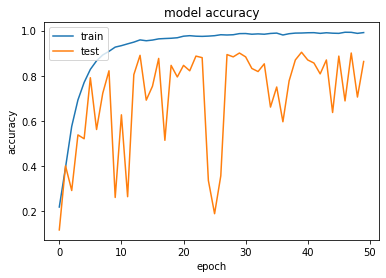

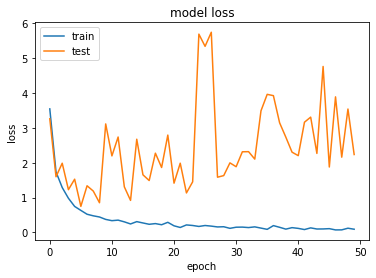

In [ ]:
import pandas as pd
history_df = pd.DataFrame(model.history.history)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
top5_trainacc = history_df["accuracy"].sort_values(ascending=False)[:5]
top5_valacc = history_df["val_accuracy"].sort_values(ascending=False)[:5]

In [ ]:
Top5results = pd.DataFrame({'train_Top5 Acc': list(top5_trainacc), 'val_Top5 Acc' : list(top5_valacc)})

In [ ]:
score = model.evaluate(x_valid, y_valid, verbose=1)

292/292 [==============================] - 4s 12ms/step


In [ ]:
print(f'Val_loss : {score[0]}\nVal_Acc: {score[1]}')

Val_loss : 1.776025948459155
Val_Acc: 0.9178082346916199


In [ ]:
y_pred = np.argmax(model.predict(x_valid), axis=1)
y_valid = np.argmax(y_valid, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_valid, y_pred))
print('Classification Report')
target_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
print(classification_report(y_valid, y_pred, target_names=target_names))

Confusion Matrix
[[38  0  1  1  0  0  0]
 [ 0 32  0  0  0  2  0]
 [ 0  0 37  0  1  2  2]
 [ 0  0  0 37  1  0  0]
 [ 1  0  0  0 44  2  0]
 [ 0  1  1  0  4 34  0]
 [ 0  0  4  0  1  0 46]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.97      0.95      0.96        40
     Disgust       0.97      0.94      0.96        34
        Fear       0.86      0.88      0.87        42
       Happy       0.97      0.97      0.97        38
     Neutral       0.86      0.94      0.90        47
         Sad       0.85      0.85      0.85        40
    Surprise       0.96      0.90      0.93        51

    accuracy                           0.92       292
   macro avg       0.92      0.92      0.92       292
weighted avg       0.92      0.92      0.92       292



Text(33.0, 0.5, "('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')")

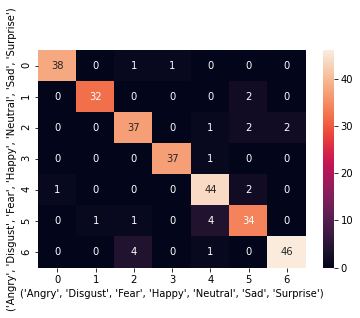

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

ax = sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt="d")
ax.set_xlabel(tuple(target_names))
ax.set_ylabel(tuple(target_names))